<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
code = '004590'
start_date = '20000101'
end_date = '20220301'
# freq: day, week, month

periods = 120 

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast
import re

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_info(self):
    url = 'https://finance.naver.com/item/main.naver?code=' + code
    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    cap = bs_obj.find_all('table', {'summary':'시가총액 정보'})[0].find('td').text
    cap = int(''.join(re.findall("\d+", cap)))
    pbr = float(bs_obj.find_all('table', {'summary':'PER/EPS 정보'})[0].find_all('em', {'id':"_pbr"})[0].text)
    per = bs_obj.find_all('table', {'summary':'PER/EPS 정보'})[0].find('td').text[:15]
    per = float(re.findall("\d+\.\d+", per)[0])
    sector_per = bs_obj.find_all('table', {'summary':'동일업종 PER 정보'})[0].find('td').text[:15]
    sector_per = float(re.findall("\d+\.\d+", sector_per)[0])
    return {'cap': cap, 'pbr': pbr, 'per': per, 'sector_per': sector_per}

  def get_price(self, start='20180501', end=str(datetime.datetime.now().date().strftime("%Y%m%d")), interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + '&requestType=1&startTime=' \
    + start + '&endTime=' + end + '&timeframe=' + interval
    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], float), 'High':np.array(data[:,2], float), 'Low':np.array(data[:,3], float),\
       'Close':np.array(data[:,4], float), 'Volume':np.array(data[:,5], float)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    df['Change'] = df['Close'][1:]/df['Close'][:-1].values
    df = df[1:]
    return df

In [3]:
stock = Stock(code)
df = stock.get_price(start_date, end_date)

Monte Carlo Simulation

In [4]:
s = datetime.datetime.strptime(end_date, '%Y%m%d')

In [5]:
from datetime import datetime, date
import random
import math

m = df['Change'].mean()
var = df['Change'].var()

sample_num = 1000

dates = pd.date_range(start=s, periods=periods)
close_li = [pd.DataFrame({'Change':[random.gauss(m, math.sqrt(var)) for i in range(periods)]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * df['Close'][-1], close_li))

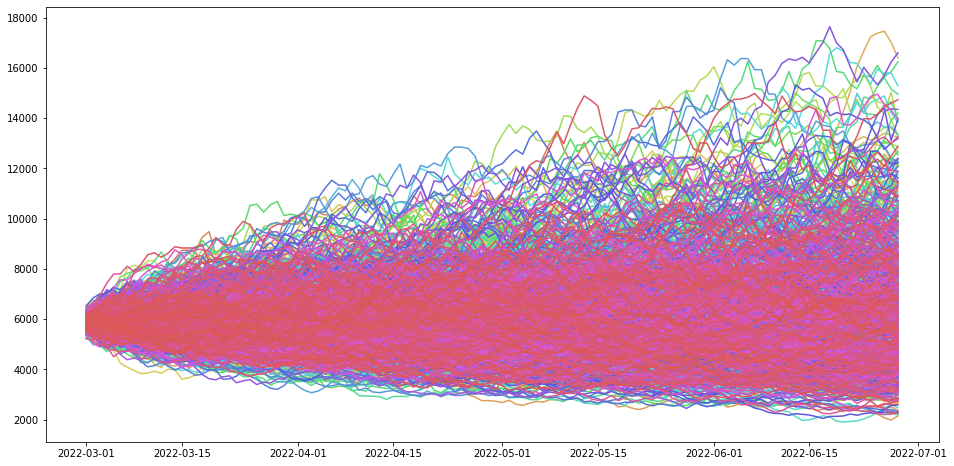

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

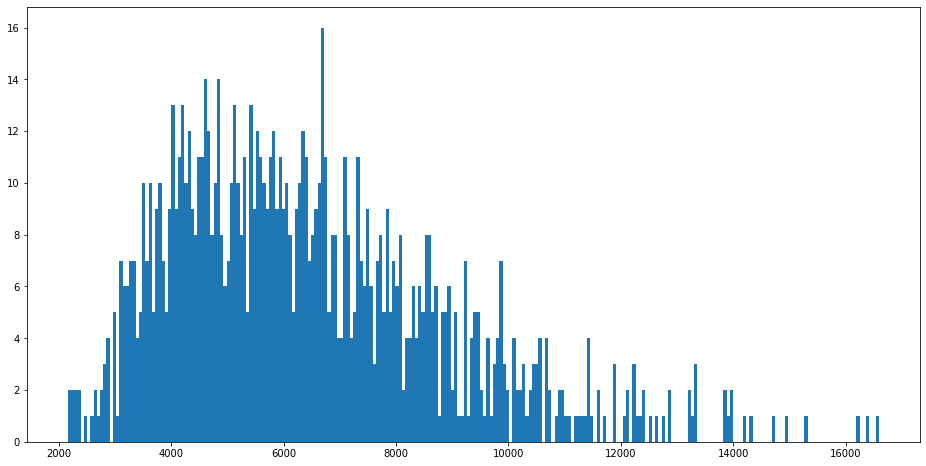

In [7]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [8]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
print('Mean: ', np.mean([round(x.iloc[-1].values[0],0) for x in close_li]))

# 중앙
print('Median: ', np.median([round(x.iloc[-1].values[0],0) for x in close_li]))

95% Min:  6290
95% Max:  6595
Mean:  6442.577
Median:  6016.5


Circular Block Bootstrap

In [9]:
block = round(periods ** (1/2))
data = list(df['Change'][-periods:].values)
ccb = [(data+data[:block])[x:block+x] for x in range(len(data))]

In [10]:
change = [j for sub in random.sample(ccb, int(periods/block)) for j in sub]

In [11]:
import random
#change = [j for sub in random.sample(ccb, int(periods/block)) for j in sub]

periods = len(change)
dates = pd.date_range(start=s, periods=periods)
close_li = [pd.DataFrame({'Change':[j for sub in random.sample(ccb, int(periods/block)) for j in sub]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * df['Close'][-1], close_li))

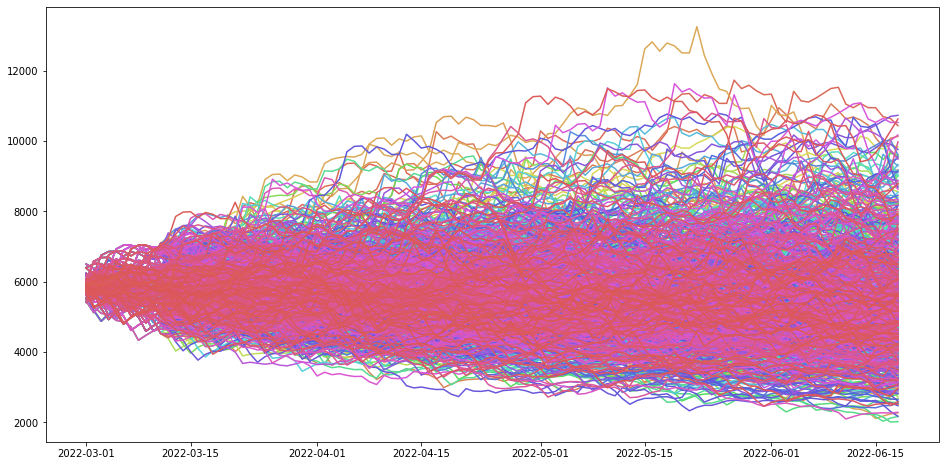

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

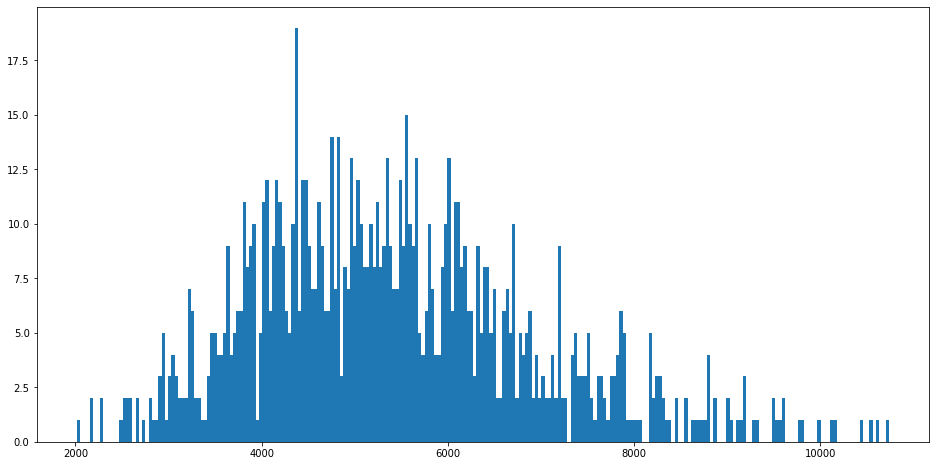

In [13]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [14]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
print('Mean: ', np.mean([round(x.iloc[-1].values[0],0) for x in close_li]))

# 중앙
print('Median: ', np.median([round(x.iloc[-1].values[0],0) for x in close_li]))

95% Min:  5328
95% Max:  5514
Mean:  5420.973
Median:  5259.5


In [15]:
df['Close']

Date
2000-01-05    1620.0
2000-01-06    1520.0
2000-01-07    1460.0
2000-01-10    1540.0
2000-01-11    1490.0
               ...  
2022-02-22    5500.0
2022-02-23    5560.0
2022-02-24    5510.0
2022-02-25    5600.0
2022-02-28    5890.0
Name: Close, Length: 5469, dtype: float64